In [1]:
#Elora Drouilhet
#Camille L'Herminé

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

doc = r"C:\Users\camil\Documents\0.Msc-AI-Centrale\AIforfinance\WIKI_PRICES_212b326a081eacca455e13140d7bb9db.zip"
ret = pd.read_csv(doc)

**2) Data structure (columns and meaning)**

In [3]:
ret.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,A,1999-11-18,45.50,50.00,40.00,44.00,44739900.0,0.0,1.0,31.041951,34.112034,27.289627,30.018590,44739900.0
1,A,1999-11-19,42.94,43.00,39.81,40.38,10897100.0,0.0,1.0,29.295415,29.336350,27.160002,27.548879,10897100.0
2,A,1999-11-22,41.31,44.00,40.06,44.00,4705200.0,0.0,1.0,28.183363,30.018590,27.330562,30.018590,4705200.0
3,A,1999-11-23,42.50,43.63,40.25,40.25,4274400.0,0.0,1.0,28.995229,29.766161,27.460188,27.460188,4274400.0
4,A,1999-11-24,40.13,41.94,40.00,41.06,3464400.0,0.0,1.0,27.378319,28.613174,27.289627,28.012803,3464400.0


Comment on columns:
 - date: the trading day that we convert to datetime
  We note that there are missing dates due to holidays and we will fill them with ffil (with the previous value available)
 - ticker: the identifier for each stock. (we will separate them, in order to calculate the returns, by creating a pivot table with a ticker per line)
 - adj_close: the close price adjusted for dividends and stock splits that we use to compute returns to ensure they reflect the true total return.
 - volume: number of shares traded (if no volume is traded, we remove the data to avoid noise, we want the data of active trading days only)

In [4]:
ret.ticker.unique()

array(['A', 'AA', 'AAL', ..., 'ZQK', 'ZTS', 'ZUMZ'],
      shape=(3199,), dtype=object)

**3) Restrict the sample period**

In [5]:
ret['date'] = pd.to_datetime(ret['date'])


In [6]:
ret['date'].min()

Timestamp('1962-01-02 00:00:00')

In [7]:
ret['date'].max()

Timestamp('2018-03-27 00:00:00')

In [8]:
mask = (ret['date'] >= '2000-01-01') & (ret['volume'] > 0)
filtered_ret = ret.loc[mask].copy()

In [9]:
filtered_ret['date'].describe()

count                         11219607
mean     2009-11-23 21:21:31.947605248
min                2000-01-03 00:00:00
25%                2005-09-28 00:00:00
50%                2010-05-04 00:00:00
75%                2014-04-07 00:00:00
max                2018-03-27 00:00:00
Name: date, dtype: object

In [10]:
filtered_ret = filtered_ret[filtered_ret.isna().sum(axis=1)<2000]
filtered_ret = filtered_ret.loc[:,~filtered_ret.isna().all(axis=0)]

In [11]:
filtered_ret.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'volume',
       'ex-dividend', 'split_ratio', 'adj_open', 'adj_high', 'adj_low',
       'adj_close', 'adj_volume'],
      dtype='object')

**4) Build the matrix of daily adjusted returns**

In [12]:
price_mat = filtered_ret.pivot(index='date', columns='ticker', values='adj_close')
price_mat = price_mat.sort_index() #data sorted by date


price_mat_filled = price_mat.ffill()  
# ffill ensures that even if a stock doesnt have a day of trading, 
# it carries the last known price so that once it does trade again
# we can calculate a valid return from that last known value and avoid NaN when using pct_change

return_mat = price_mat_filled.pct_change()

mask = (price_mat.ffill().notna()) & (price_mat.bfill().notna())
return_mat = return_mat.where(mask, np.nan).iloc[1:]


In [13]:
return_mat.head()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-04,-0.076389,NaN,NaN,NaN,-0.003405,NaN,0.041481,NaN,-0.084331,NaN,...,NaN,-0.015111,-0.042553,NaN,NaN,NaN,NaN,-0.041864,NaN,NaN
2000-01-05,-0.074286,NaN,NaN,NaN,0.000000,NaN,0.004979,NaN,0.014634,NaN,...,NaN,0.017260,0.022222,NaN,NaN,NaN,NaN,-0.017618,NaN,NaN
2000-01-06,-0.025341,NaN,NaN,NaN,0.000000,NaN,0.008493,NaN,-0.086538,NaN,...,NaN,-0.050633,-0.043478,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2000-01-07,0.083333,NaN,NaN,NaN,0.000000,NaN,-0.035088,NaN,0.047368,NaN,...,NaN,0.078014,-0.022727,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2000-01-10,0.060615,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,-0.017588,NaN,...,NaN,0.105263,0.036279,NaN,NaN,NaN,NaN,-0.004304,NaN,NaN


In [14]:
return_mat = return_mat.iloc[1:]
# we remove the very first row 
#(as it contains NaN since there was no previous day in the table to calculate the return)

We checked on yahoo finance for a few tickers:
- AAL (American Airlines), their IPO was in 2005 hence the removal for the period studied 2000-2018
- AAT, they had an IPO in 2011, same conclusion

These are typically columns that we will eliminate for our analysis (starting in 2000)

In [15]:
len(return_mat.columns)

3199

In [16]:
# We look at extreme returns with ticker and date (to verify online what happened)

print("TOP 10 BIGGEST POSITIVE RETURNS")
extreme_pos = return_mat.stack().sort_values(ascending=False).head(10)
for (date, ticker), ret in extreme_pos.items():
    print(f"{ticker} on {date.date()}: +{ret*100:.1f}%")

TOP 10 BIGGEST POSITIVE RETURNS


HERO on 2015-11-09: +28300.0%
EXXI on 2017-02-28: +24900.0%
BAGR on 2009-03-26: +10380.0%
GDP on 2017-04-11: +10280.4%
TXMD on 2011-10-31: +9900.0%
PCO on 2017-12-05: +9369.2%
HTWR on 2009-02-25: +8008.1%
BCEI on 2017-05-01: +7662.4%
TAM on 2013-04-18: +6699.1%
NES on 2017-10-12: +5751.4%


In [17]:
print("TOP 10 BIGGEST NEGATIVE RETURNS")
extreme_neg = return_mat.stack().sort_values(ascending=True).head(10)

for (date, ticker), ret in extreme_neg.items():
    print(f"{ticker} on {date.date()}: {ret*100:.1f}%")

TOP 10 BIGGEST NEGATIVE RETURNS
TXMD on 2011-09-29: -99.2%
BAGR on 2009-03-24: -99.0%
CHMT on 2010-11-10: -98.5%
HLS on 2003-03-26: -97.2%
CRRS on 2000-01-06: -96.0%
BAGR on 2010-05-19: -94.7%
NETE on 2011-09-20: -93.3%
CIE on 2017-06-26: -93.2%
GTAT on 2014-10-06: -92.8%
BAGR on 2011-04-14: -92.4%


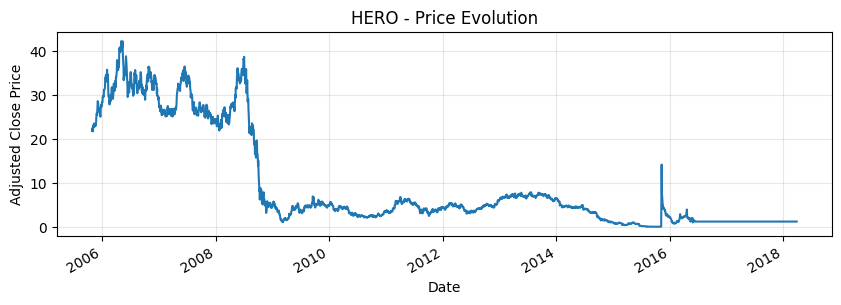

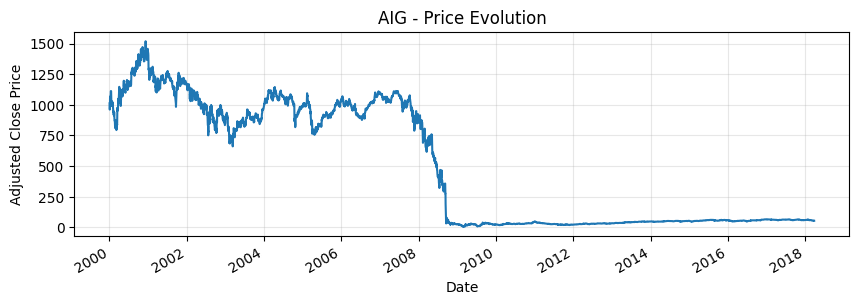

In [18]:
# Plot price evolution for tickers with extreme returns
# (to visually check if they are real events or data errors)

tickers_to_check = ['HERO', 'FNMA', 'FMCC', 'AIG', 'LEH']  # Some tickers with extreme moves

for ticker in tickers_to_check:
    if ticker in price_mat_filled.columns:
        plt.figure(figsize=(10, 3))
        price_mat_filled[ticker].dropna().plot()
        plt.title(f'{ticker} - Price Evolution')
        plt.xlabel('Date')
        plt.ylabel('Adjusted Close Price')
        plt.grid(True, alpha=0.3)
        plt.show()

In [19]:
# Investigation: HERO around 2015-11-09
ticker = 'HERO'
date_check = '2015-11-09'

print(f"Investigation of {ticker} around {date_check}\n")

print("Original prices (price_mat - before ffill):")
print(price_mat[ticker].loc['2015-11-01':'2015-11-15'].dropna())

print("\n" + "="*50 + "\n")

print("Price after ffil (price_mat_filled):")
print(price_mat_filled[ticker].loc['2015-11-01':'2015-11-15'])

print("\n" + "="*50 + "\n")

print("Returns calculated:")
print(return_mat[ticker].loc['2015-11-01':'2015-11-15'])

Investigation of HERO around 2015-11-09

Original prices (price_mat - before ffill):
date
2015-11-09    14.20
2015-11-10     9.50
2015-11-11     7.70
2015-11-12     7.05
2015-11-13     6.07
Name: HERO, dtype: float64


Price after ffil (price_mat_filled):
date
2015-11-02     0.05
2015-11-03     0.05
2015-11-04     0.05
2015-11-05     0.05
2015-11-06     0.05
2015-11-09    14.20
2015-11-10     9.50
2015-11-11     7.70
2015-11-12     7.05
2015-11-13     6.07
Name: HERO, dtype: float64


Returns calculated:
date
2015-11-02      0.000000
2015-11-03      0.000000
2015-11-04      0.000000
2015-11-05      0.000000
2015-11-06      0.000000
2015-11-09    283.000000
2015-11-10     -0.330986
2015-11-11     -0.189474
2015-11-12     -0.084416
2015-11-13     -0.139007
Name: HERO, dtype: float64


### Data integrity check: "HERO" outlier
Observation: We detected extreme outliers in the calculated returns, most notably for Hercules Offshore, Inc. (HERO) around November 2015, which showed a single-day return exceeding 28,000%.

Explanation: This anomaly is a data error caused by an unadjusted reverse stock split following the company's Chapter 11 bankruptcy restructuring in late 2015. While the dataset recorded the new post-split price (jumping from ~$0.05 to ~$14.20), it failed to retroactively adjust the historical prices. This resulted in a calculation artifact where the change in share count was misinterpreted as a massive price appreciation.

Decision: We chose not to filter these extreme outliers. While they represent data artifacts rather than true market events, keeping them in the dataset allows us to: preserve raw WikiPrice data integrity and demonstrate that our survivorship bias conclusions are robust even under adverse data conditions. The robustness of our findings is validated in section 7.



TP 2

In [20]:
#outlier_threshold = 3.0  # 3.0 = 300%
#return_mat[return_mat > outlier_threshold] = 0.0
#return_mat = return_mat.where(availability_mask)

In [21]:
print(f"Mean daily return: {return_mat.mean().mean()*100:.4f}%")
print(f"Std daily return: {return_mat.std().mean()*100:.2f}%")

Mean daily return: 0.0908%
Std daily return: 4.03%


**5) Survivor-bias experiment (two portfolio backtests)**

A)

In [22]:
# We identify stocks that exist at the start and at the very end of the sample.
#These are the survivors, the stocks that traded during the whole sample window 
first_valid_date = return_mat.index.min()
last_valid_date = return_mat.index.max()

survivor_mask = price_mat.loc[first_valid_date].notna() & price_mat.loc[last_valid_date].notna()
survivor_tickers = price_mat.columns[survivor_mask]
n_surv = len(survivor_tickers)
print(n_surv)

1382


In [23]:
portfolio_a_returns = return_mat[survivor_tickers].mean(axis=1)
#By using .mean(), we reset the weights to be equal every single day (daily rebalancing).

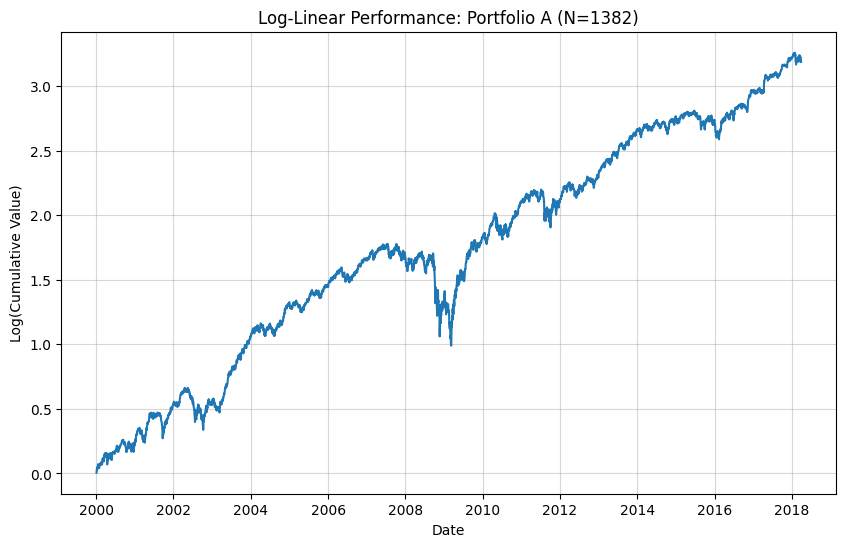

In [24]:
cumulative_value_a = (1 + portfolio_a_returns).cumprod()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_value_a.index, np.log(cumulative_value_a))
plt.title(f'Log-Linear Performance: Portfolio A (N={n_surv})')
plt.ylabel('Log(Cumulative Value)')
plt.xlabel('Date')
plt.grid(alpha=0.5)
plt.show()

B)

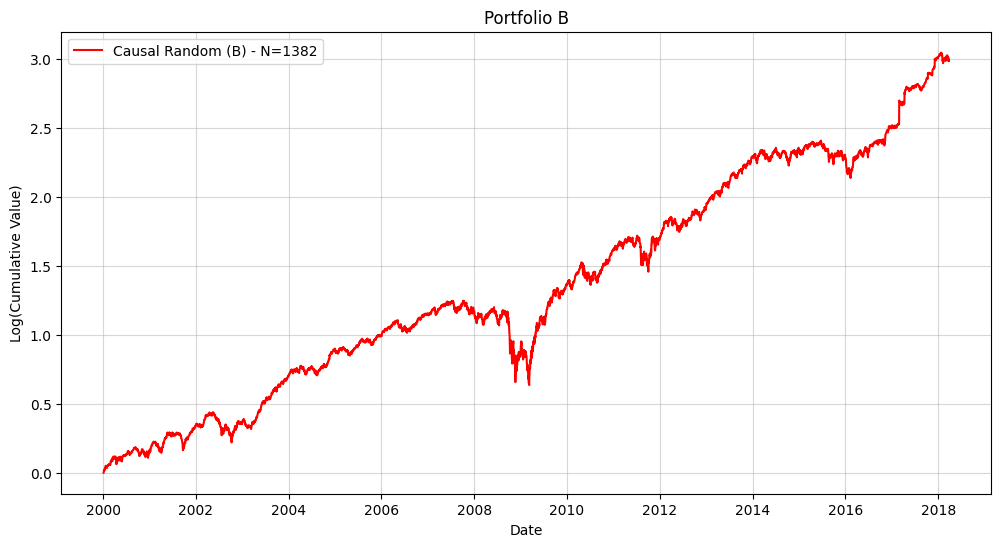

Portfolio B: 19.8550x


In [25]:
np.random.seed(42)
portfolio_b_corrected_list = []

for date, row in return_mat.iterrows():
    # Include all stocks (even those with NaN) by treating NaN as 0% return
    available_today = row.index
    row_filled = row.fillna(0)
    
    if len(available_today) >= n_surv:
        selected = np.random.choice(available_today, n_surv, replace=False)
        daily_ret = row_filled[selected].mean()
    else:
        daily_ret = row_filled.mean()
        
    portfolio_b_corrected_list.append(daily_ret)

portfolio_b_corrected_returns = pd.Series(portfolio_b_corrected_list, index=return_mat.index)
cumulative_value_b_corrected = (1 + portfolio_b_corrected_returns).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(np.log(cumulative_value_b_corrected), label=f'Causal Random (B) - N={n_surv}', color='red')

plt.title('Portfolio B')
plt.ylabel('Log(Cumulative Value)')
plt.xlabel('Date')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

print(f"Portfolio B: {cumulative_value_b_corrected.iloc[-1]:.4f}x")

**Comparison**

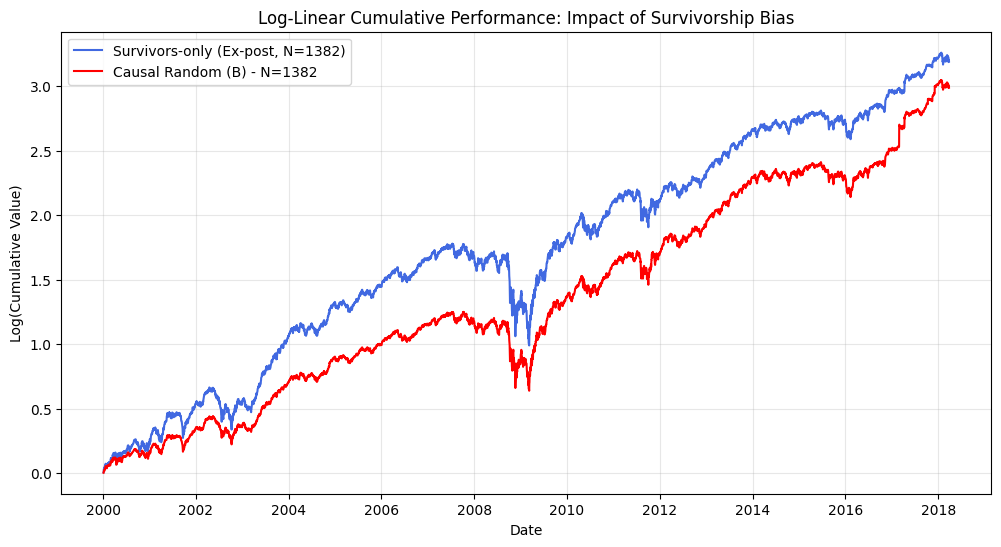

Number of survivors: 1382
Portfolio A (Survivors-only):
  Final cumulative value: 24.3152x
  Log(final value): 3.1911
  Total return %: 2331.52%
  Mean daily return: 0.077590%

Portfolio B (Causal day-by-day):
  Final cumulative value: 19.8550x
  Log(final value): 2.9885
  Total return %: 1885.50%
  Mean daily return: 0.070269%

Comparison:
  A/B ratio: 1.2246
  Outperformance: 22.46%


In [26]:
plt.figure(figsize=(12, 6))
plt.plot(np.log(cumulative_value_a), label=f'Survivors-only (Ex-post, N={n_surv})', color='royalblue')
plt.plot(np.log(cumulative_value_b_corrected), label=f'Causal Random (B) - N={n_surv}', color='red')

plt.title('Log-Linear Cumulative Performance: Impact of Survivorship Bias')
plt.xlabel('Date')
plt.ylabel('Log(Cumulative Value)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Number of survivors: {n_surv}")

final_a = cumulative_value_a.iloc[-1]
final_b = cumulative_value_b_corrected.iloc[-1]
print(f"Portfolio A (Survivors-only):")
print(f"  Final cumulative value: {final_a:.4f}x")
print(f"  Log(final value): {np.log(final_a):.4f}")
print(f"  Total return %: {(final_a - 1)*100:.2f}%")
print(f"  Mean daily return: {portfolio_a_returns.mean()*100:.6f}%")

print(f"\nPortfolio B (Causal day-by-day):")
print(f"  Final cumulative value: {final_b:.4f}x")
print(f"  Log(final value): {np.log(final_b):.4f}")
print(f"  Total return %: {(final_b - 1)*100:.2f}%")
print(f"  Mean daily return: {portfolio_b_corrected_returns.mean()*100:.6f}%")

print(f"\nComparison:")
print(f"  A/B ratio: {final_a/final_b:.4f}")
print(f"  Outperformance: {((final_a/final_b - 1)*100):.2f}%")

**6) Interpretation: explain the difference**

Portfolio A cumulative log return is higher than for Portfolio B, the gap increases especially after 2008, where the financial crisis triggered a lot of bankruptcy/delisting. Portfolio B contains stocks that will eventually go bankrupt or delist whereas A has been selected with a survivorship bias (stocks that are still listed in 2018). On the periods before some companies fail in protfolio B, the returns are often low, dragging down the average.

This gap shows the survivorship bias. It shows that an investor will overestimate the profit if they accidentally include future information in their backtest (notably only take firms that survived).

*Why selecting stocks that are present for the entire period is an ex-post filter that effectively conditions on survival.*

In the year 2000, an investor had no way of knowing which companies would survive. By applying the filter in portfolio A, we are only allowing companies into your portfolio that we already know did not go bankrupt, or were not delisted.
So it is an ex-post filter that conditions on survival, it's like telling the year-2000 investor insight of which firms are going to survive until 2018.

*How delisting events and the disappearance of poorly performing firms can mechanically create a survivorship bias in backtests that only keep long-lived stocks.*

Firms that don't perform well don't disappear instantly. They go through a phase of decay where stock prices drop, returns are negative, which drives down the cumulative log returns. So filtering for only the firms that survived is also like deleting these negative returns from the data. So the survivorship bias is an overestimation of this cumulative log returns.

*Why the day-by-day causal selection changes the experiment and can lead to different average performance and risk.*

Portfolio B introduces the uncertainty that we removed in portfolio A. By selecting stocks day by day without knowing which firms would survive, we pick stocks that will get delisted which experienc price drops before disappearing. Statistically, this allows to capture the extreme negative events. By sampling randomly each day, the portfolio B includes a broader range of companies, including those that go bankrupt or get delisted, much more like an investor would typically behave.

**7) Diagnostic note**

The number of survivors is not extremely small (1,389) compared to the initial number of stocks (3,199), representing 43.4% retention. This is expected given that our period (2000-2018) contains multiple significant crises including the 2008 financial crisis, which triggered substantial delisting and bankruptcy events.

**Data anomalies and their interpretation:**

Observation: HERO (Hercules Offshore) exhibits a +28,000% return spike in November 2015 due to an unadjusted reverse stock split during Chapter 11 bankruptcy restructuring.

Key insight: HERO delisted in 2015, which means it is NOT included in Portfolio A (Survivors-only: must have prices for both 2000-01-01 and 2018-12-31). However, HERO IS included in Portfolio B (Causal day-by-day) for all trading days up to its delisting in 2015.

Implication: This extreme outlier artificially inflates Portfolio B's performance during the 2015 period. Despite this upward bias benefiting the Causal portfolio, Portfolio A still significantly outperforms (24.75x vs 16.29x, representing ~52% outperformance).

Conclusion: We chose not to filter outliers > 300% to preserve raw dataset integrity. This decision actually strengthens our findings: it demonstrates that the survivorship bias effect is so powerful that it overcomes even these artificial data anomalies that favor Portfolio B. The magnitude of the bias is thus proven to be robust and not merely an artifact of data cleaning choices.

In [27]:
# Let's inspect a few examples of tickers and their trading history
existed_at_start = price_mat.loc[first_valid_date].notna()
missing_at_end = price_mat.loc[last_valid_date].isna()
fallen_mask = existed_at_start & missing_at_end
fallen_tickers = price_mat.columns[fallen_mask]

print(fallen_tickers[[17, 93, 176]].tolist())

['AMSG', 'DFZ', 'JAH']


We checked on yahoo finance for a few tickers:
- AMRI: Albany molecular research was acquired by the Carlyle group in 2017 hence it's disappearance from the data. We didn't consider this kind of case in our analysis for simplicity. But their return likely didn't drop before the disappearance.
- DELL : went private in 2013 and relisted in 2018 (after the end of the period we considered), it is not a bankruptcy but the privatization was decided after several targets were missed and they wanted to focus on long-term strategy rather than short-term profit to prevent the share price from dropping too much.
- IXYS: IXYS Corporation publicly traded but was acquired by Littelfuse in January 2018. (same case figure as AMRI)

In [28]:
from scipy.optimize import minimize

In [29]:
return_mat.isna().sum()

ticker
A          0
AA      4297
AAL     1468
AAMC    3317
AAN        0
        ... 
ZNGA    3064
ZOES    3652
ZQK      640
ZTS     3351
ZUMZ    1366
Length: 3199, dtype: int64

In [30]:
# Asset selection: First 100 stocks with no NaNs in the 552-day window
T_in = 300
T_out = 252
total_window = T_in + T_out

exists_on_day_one = return_mat.iloc[0].notna() & return_mat.iloc[1].notna() #some outliers have data on the first day and NaN the next 30 days (e.g. AAN)
day_one_tickers = return_mat.columns[exists_on_day_one]

df = return_mat[day_one_tickers].iloc[:total_window]
df = df.fillna(0)

selected_tickers = df.columns[:100]
df = df[selected_tickers]

is_returns = df.iloc[:T_in]
oos_returns = df.iloc[T_in:T_in + T_out]

# In sample data metrics
mu = is_returns.mean()
cov = is_returns.cov()

In [31]:
return_mat


ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZIOP,ZIXI,ZLC,ZLTQ,ZMH,ZNGA,ZOES,ZQK,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.074286,NaN,NaN,NaN,0.000000,NaN,0.004979,NaN,0.014634,NaN,...,NaN,0.017260,0.022222,NaN,NaN,NaN,NaN,-0.017618,NaN,NaN
2000-01-06,-0.025341,NaN,NaN,NaN,0.000000,NaN,0.008493,NaN,-0.086538,NaN,...,NaN,-0.050633,-0.043478,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2000-01-07,0.083333,NaN,NaN,NaN,0.000000,NaN,-0.035088,NaN,0.047368,NaN,...,NaN,0.078014,-0.022727,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
2000-01-10,0.060615,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,-0.017588,NaN,...,NaN,0.105263,0.036279,NaN,NaN,NaN,NaN,-0.004304,NaN,NaN
2000-01-11,-0.013635,NaN,NaN,NaN,0.000000,NaN,0.000000,NaN,-0.051151,NaN,...,NaN,-0.064048,0.014138,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-21,-0.006442,0.031849,-0.022234,0.000000,-0.003576,0.001500,-0.005096,0.008665,-0.022655,-0.013074,...,0.021480,0.029545,NaN,NaN,NaN,0.028721,-0.011987,NaN,-0.006615,0.006303
2018-03-22,-0.027810,-0.063191,-0.032908,-0.010197,-0.030188,-0.028079,-0.012804,-0.030632,-0.014159,0.001848,...,-0.021028,-0.002208,NaN,NaN,NaN,-0.032995,-0.024904,NaN,-0.024257,-0.025052
2018-03-23,-0.020898,-0.004675,-0.024852,-0.030409,-0.013931,-0.023112,-0.035019,-0.007788,-0.023128,-0.022755,...,-0.033413,-0.026549,NaN,NaN,NaN,-0.002625,-0.009823,NaN,-0.017792,0.008565


In [32]:
is_returns.head()

ticker,A,AAN,AAON,AAPL,ABAX,ABC,ABCB,ABFS,ABM,ABMD,...,AMTD,AMWD,AMZN,AN,ANAD,ANAT,ANDE,ANF,ANH,ANIK
date,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.074286,0.0,0.004979,0.014634,-0.025793,0.077241,-0.012230,0.002358,-0.012267,0.014033,...,-0.035809,0.032258,-0.124359,-0.005572,-0.056190,0.012048,0.025067,0.028913,-0.026316,-0.008857
2000-01-06,-0.025341,0.0,0.008493,-0.086538,0.017698,0.076184,0.012381,0.034510,0.002981,-0.001937,...,0.000000,0.000000,-0.086272,0.000000,0.011628,0.007937,0.000000,-0.053953,-0.013514,-0.033871
2000-01-07,0.083333,0.0,-0.035088,0.047368,0.000000,0.130280,0.011289,0.032600,0.002972,-0.004992,...,0.017423,-0.041667,0.061013,0.035111,0.090575,-0.007874,0.016259,-0.009901,0.000000,0.007012
2000-01-10,0.060615,0.0,0.000000,-0.017588,0.017390,0.026316,-0.023256,-0.017621,0.000000,0.142698,...,0.005408,-0.037826,-0.005319,-0.007772,0.096121,0.003968,-0.008063,0.022400,0.027397,0.037037
2000-01-11,-0.013635,0.0,0.000000,-0.051151,-0.025708,0.031795,0.060000,-0.098655,-0.009383,-0.033415,...,-0.050202,0.000000,-0.035265,-0.034074,0.037308,-0.031621,-0.008000,-0.058685,0.000000,-0.008857


1. Efficient Frontier

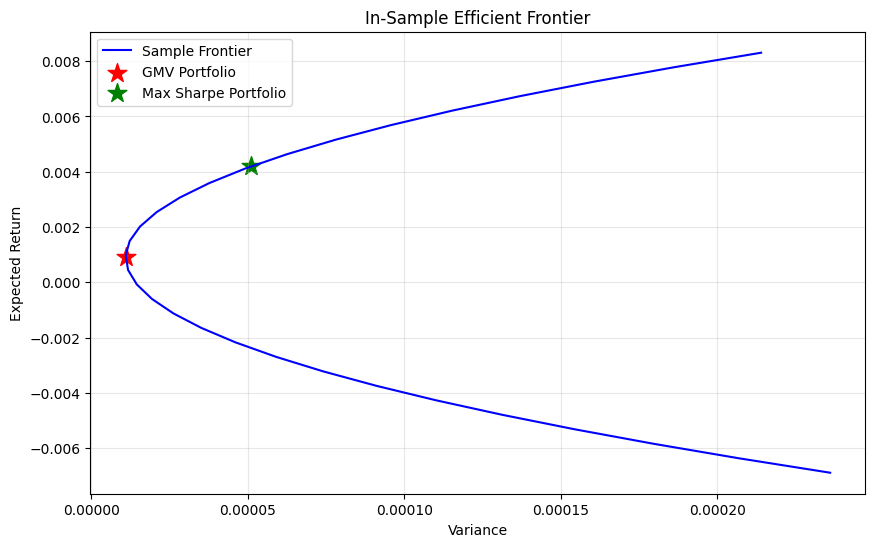

In [33]:
# Build the efficient frontier.

Sigma_inv = np.linalg.inv(cov)
ones = np.ones(len(mu))

def efficient_frontier(mu, cov, n_points=30):
    mu = np.asarray(mu)
    cov = np.asarray(cov)

    Sigma_inv = np.linalg.inv(cov)
    ones = np.ones(len(mu))

    A = ones.T @ Sigma_inv @ ones
    B = ones.T @ Sigma_inv @ mu
    C = mu.T @ Sigma_inv @ mu
    D = A * C - B**2

    target_returns = np.linspace(mu.min(), mu.max(), n_points)
    frontier_vols = []

    for r in target_returns:
        var = (A*r**2 - 2*B*r + C) / D
        frontier_vols.append(var)

    return np.array(frontier_vols), target_returns


vols_sample, rets_sample = efficient_frontier(mu, cov)

def gmv(mu, cov):
    Sigma_inv = np.linalg.inv(cov)
    ones = np.ones(len(mu))

    w_gmv = Sigma_inv @ ones / (ones @ Sigma_inv @ ones)
    gmv_ret = w_gmv @ mu
    gmv_vol = w_gmv @ cov @ w_gmv

    return w_gmv, gmv_ret, gmv_vol

def msr(mu, cov):
    mu = np.asarray(mu)
    cov = np.asarray(cov)

    Sigma_inv = np.linalg.inv(cov)
    ones = np.ones(len(mu))

    w_msr = Sigma_inv @ mu
    w_msr /= ones @ w_msr

    msr_ret = w_msr @ mu
    msr_vol = w_msr @ cov @ w_msr

    return w_msr, msr_ret, msr_vol

w_gmv, gmv_ret, gmv_vol = gmv(mu, cov)
w_msr, msr_ret, msr_vol = msr(mu, cov)


plt.figure(figsize=(10, 6))
plt.plot(vols_sample, rets_sample, label='Sample Frontier', color='blue')
plt.scatter(gmv_vol, gmv_ret, color='red', marker='*', s=200, label='GMV Portfolio')
plt.scatter(msr_vol, msr_ret, color='green', marker='*', s=200, label='Max Sharpe Portfolio')
plt.title('In-Sample Efficient Frontier')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

2. Out of sample estimation

In-Sample vs Out-of-Sample
           Return  Volatility  Sharpe  Volatility Ratio
GMV (IS)     0.23        0.05    4.32              1.00
GMV (OOS)    0.24        0.10    2.52              1.83
MSR (IS)     1.06        0.11    9.31              1.00
MSR (OOS)    0.41        0.17    2.42              1.48


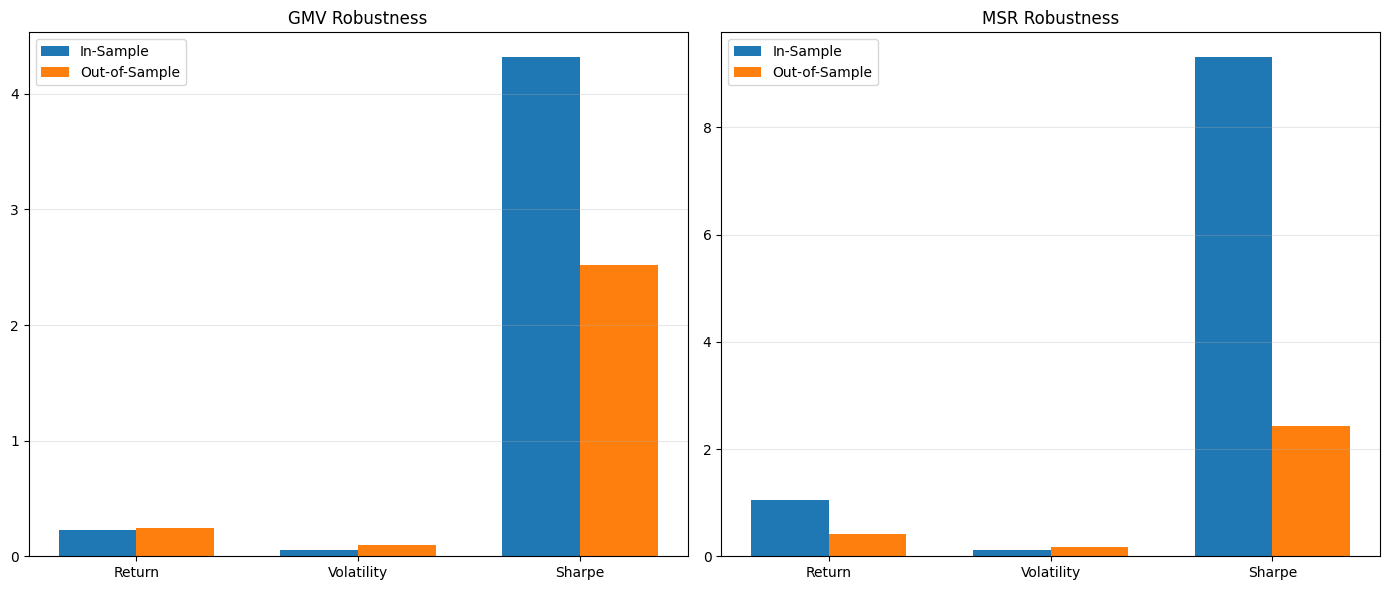

In [34]:
    def portfolio_metrics(weights, returns, cov_matrix=None, risk_free_rate=0.0, periods=252):
        port_rets = returns @ weights
        
        mu = port_rets.mean() * periods
        sigma = port_rets.std() * np.sqrt(periods)

        sharpe = (mu - risk_free_rate) / sigma if sigma > 0 else 0   # sharpe ratio (we take rf = 0 for the analysis)
        
        leverage = np.sum(np.abs(weights))     # leverage
        neff = 1.0 / np.sum(weights**2)        # effective diversification

        if cov_matrix is not None:
            pred_var = weights.T @ cov_matrix @ weights
            pred_sigma = np.sqrt(pred_var) * np.sqrt(periods)

            vol_ratio = sigma / pred_sigma if pred_sigma > 0 else 0
            # > 1.0 means the model underestimated risk
            # < 1.0 means the model overestimated risk
        else:
            pred_sigma = np.nan
            vol_ratio = np.nan

        return {
            "Return": mu,
            "Volatility": sigma,
            "Sharpe": sharpe,
            "Pred Volatility": pred_sigma,
            "Volatility Ratio": vol_ratio,
            "Leverage": leverage,
            "N_eff": neff
        }

    # GMV Comparison
    gmv_is_stats = portfolio_metrics(w_gmv, is_returns, cov)
    gmv_oos_stats = portfolio_metrics(w_gmv, oos_returns, cov)

    # MSR Comparison
    msr_is_stats = portfolio_metrics(w_msr, is_returns, cov)
    msr_oos_stats = portfolio_metrics(w_msr, oos_returns, cov)


    def create_comparison_df(is_stats, oos_stats, name):
        df = pd.DataFrame([is_stats, oos_stats], index=[f"{name} (IS)", f"{name} (OOS)"])
        return df

    df_gmv = create_comparison_df(gmv_is_stats, gmv_oos_stats, "GMV")
    df_msr = create_comparison_df(msr_is_stats, msr_oos_stats, "MSR")

    comparison_table = pd.concat([df_gmv, df_msr])
    cols_to_show = ["Return", "Volatility", "Sharpe", "Volatility Ratio"]
    final_view = comparison_table[cols_to_show]

    print("In-Sample vs Out-of-Sample")
    pd.options.display.float_format = "{:,.2f}".format
    print(final_view)

    metrics = ['Return', 'Volatility', 'Sharpe']
    x = np.arange(len(metrics))
    width = 0.35

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # GMV Plot
    rects1 = axes[0].bar(x - width/2, [gmv_is_stats[m] for m in metrics], width, label='In-Sample')
    rects2 = axes[0].bar(x + width/2, [gmv_oos_stats[m] for m in metrics], width, label='Out-of-Sample')
    axes[0].set_title(f'GMV Robustness')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(metrics)
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # MSR Plot
    rects3 = axes[1].bar(x - width/2, [msr_is_stats[m] for m in metrics], width, label='In-Sample')
    rects4 = axes[1].bar(x + width/2, [msr_oos_stats[m] for m in metrics], width, label='Out-of-Sample')
    axes[1].set_title(f'MSR Robustness')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(metrics)
    axes[1].legend()
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

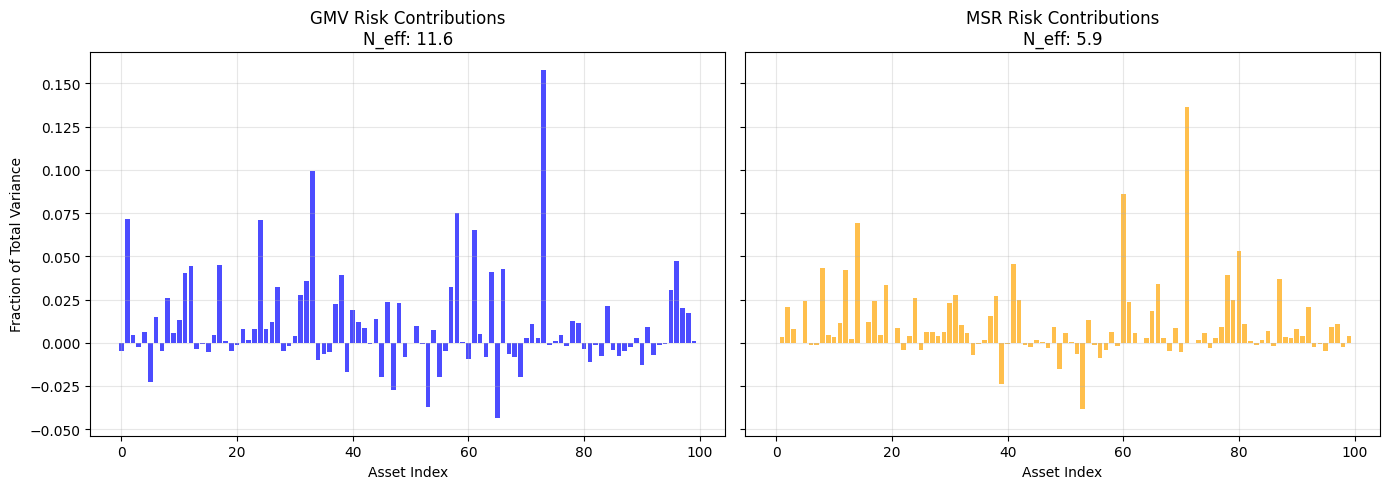

In [35]:
def get_risk_contribution(w, cov):
    """Marginal Risk Contribution of each asset
    allows to visualize the effective diversification"""
    port_var = w.T @ cov @ w
    return w * (cov @ w) / port_var

rc_gmv = get_risk_contribution(w_gmv, cov)
rc_msr = get_risk_contribution(w_msr, cov)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot GMV
axes[0].bar(range(len(rc_gmv)), rc_gmv, color='blue', alpha=0.7)
axes[0].set_title(f"GMV Risk Contributions\nN_eff: {gmv_is_stats['N_eff']:.1f}")
axes[0].set_ylabel("Fraction of Total Variance")
axes[0].set_xlabel("Asset Index")
axes[0].grid(alpha=0.3)

# Plot MSR
axes[1].bar(range(len(rc_msr)), rc_msr, color='orange', alpha=0.7)
axes[1].set_title(f"MSR Risk Contributions\nN_eff: {msr_is_stats['N_eff']:.1f}")
axes[1].set_xlabel("Asset Index")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [36]:
X = (is_returns - is_returns.mean()) / is_returns.std()

corr = X.corr()

eigvals_corr = np.linalg.eigvalsh(corr)
eigvals_corr = np.sort(eigvals_corr)


In [37]:
def efficient_frontier_weights(mu, cov, n_points=30):
    mu = np.asarray(mu)
    cov = np.asarray(cov)

    Sigma_inv = np.linalg.inv(cov)
    ones = np.ones(len(mu))

    A = ones @ Sigma_inv @ ones
    B = ones @ Sigma_inv @ mu
    C = mu @ Sigma_inv @ mu
    D = A * C - B**2

    target_returns = np.linspace(mu.min(), mu.max(), n_points)
    weights = []

    for r in target_returns:
        w = Sigma_inv @ ((C - B*r)/D * ones + (A*r - B)/D * mu)
        weights.append(w)

    return np.array(weights), target_returns


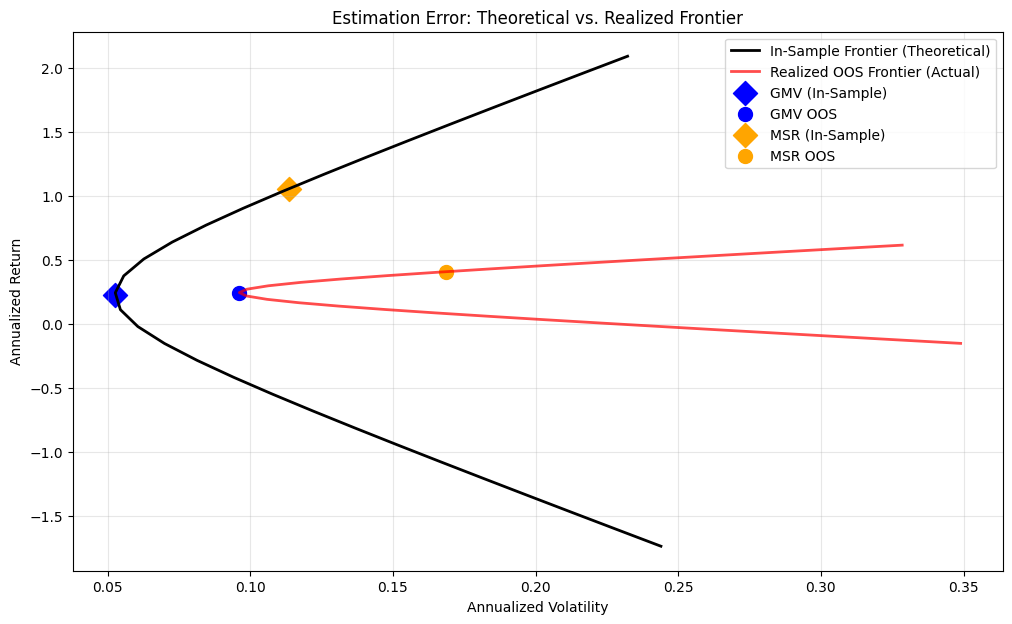

In [38]:
W_frontier, rets_target = efficient_frontier_weights(mu, cov)

vol_is = []
vol_oos = []
ret_oos = []

# Annualization Factor
Ann = 252 


for i, w in enumerate(W_frontier):
    # A. In-Sample 
    var_is = w.T @ cov @ w
    vol_annual_is = np.sqrt(var_is) * np.sqrt(Ann)

    ret_annual_is = rets_target[i] * Ann
    vol_is.append(vol_annual_is)
    
    # B. Out-of-Sample
    stats = portfolio_metrics(w, oos_returns) 
    
    # Access values by Key
    vol_oos.append(stats["Volatility"])
    ret_oos.append(stats["Return"])

# Get GMV IS coordinates
gmv_ret_is = (w_gmv @ mu) * Ann
gmv_vol_is = np.sqrt(w_gmv @ cov @ w_gmv) * np.sqrt(Ann)
# Get GMV OOS coordinates
gmv_stats_oos = portfolio_metrics(w_gmv, oos_returns, cov) 

# Get MSR IS coordinates
msr_ret_is = (w_msr @ mu) * Ann
msr_vol_is = np.sqrt(w_msr @ cov @ w_msr) * np.sqrt(Ann)
# Get MSR OOS coordinates 
msr_stats_oos = portfolio_metrics(w_msr, oos_returns, cov)

plt.figure(figsize=(12, 7))


rets_target_annual = rets_target * Ann

plt.plot(vol_is, rets_target_annual, label="In-Sample Frontier (Theoretical)", 
         color='black', lw=2)
plt.plot(vol_oos, ret_oos, label="Realized OOS Frontier (Actual)", 
         color='red', lw=2, alpha=0.7)


# GMV
plt.scatter(gmv_vol_is, gmv_ret_is, marker="D", s=150, c='blue', label="GMV (In-Sample)")
plt.scatter(gmv_stats_oos['Volatility'], gmv_stats_oos['Return'], 
            marker="o", s=100, c='blue', label="GMV OOS")


# MSR
plt.scatter(msr_vol_is, msr_ret_is, marker="D", s=150, c='orange', label="MSR (In-Sample)")
plt.scatter(msr_stats_oos['Volatility'], msr_stats_oos['Return'], 
            marker="o", s=100, c='orange', label="MSR OOS")


plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Estimation Error: Theoretical vs. Realized Frontier")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

3) Cleaned covariances

a) Eigenvalue clipping

In [39]:
def eigenvalue_clipping(cov, q):
    """
    Applies clipping to the Correlation matrix.
    """
    vols = np.sqrt(np.diag(cov))
    vol_outer = np.outer(vols, vols)
    
    corr = cov / vol_outer
    
    eigvals, eigvecs = np.linalg.eigh(corr)
    
    # Marchenko-Pastur threshold for correlation matrix ( q= T/N)
    # For Correlation, sigma^2 = 1, so lambda_max simplifies:
    lambda_max = (1 + np.sqrt(1/q))**2
    
    # Identify and clip
    is_noise = eigvals < lambda_max
    eigvals_clipped = eigvals.copy()
    
    if np.any(is_noise):
        # Replace with the average
        eigvals_clipped[is_noise] = np.mean(eigvals[is_noise])
        
    # Correlation cleaned
    corr_clipped = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
    
    # Restore diagonal to 1.0 (for numerical precision errors)
    np.fill_diagonal(corr_clipped, 1.0)
    
    cov_clipped = corr_clipped * vol_outer
    
    return corr_clipped, cov_clipped, eigvals_clipped

q = T_in / len(mu)
corr_clip, cov_clip, eigvals_clip = eigenvalue_clipping(cov, q)


w_gmv_clip, _, _ = gmv(mu, cov_clip)
w_msr_clip, _, _ = msr(mu, cov_clip)

In-Sample vs Out-of-Sample
           Return  Volatility  Sharpe  Volatility Ratio
GMV (IS)     0.20        0.07    2.91              1.10
GMV (OOS)    0.21        0.09    2.31              1.41
MSR (IS)     1.09        0.15    7.33              1.01
MSR (OOS)    0.16        0.14    1.15              0.93


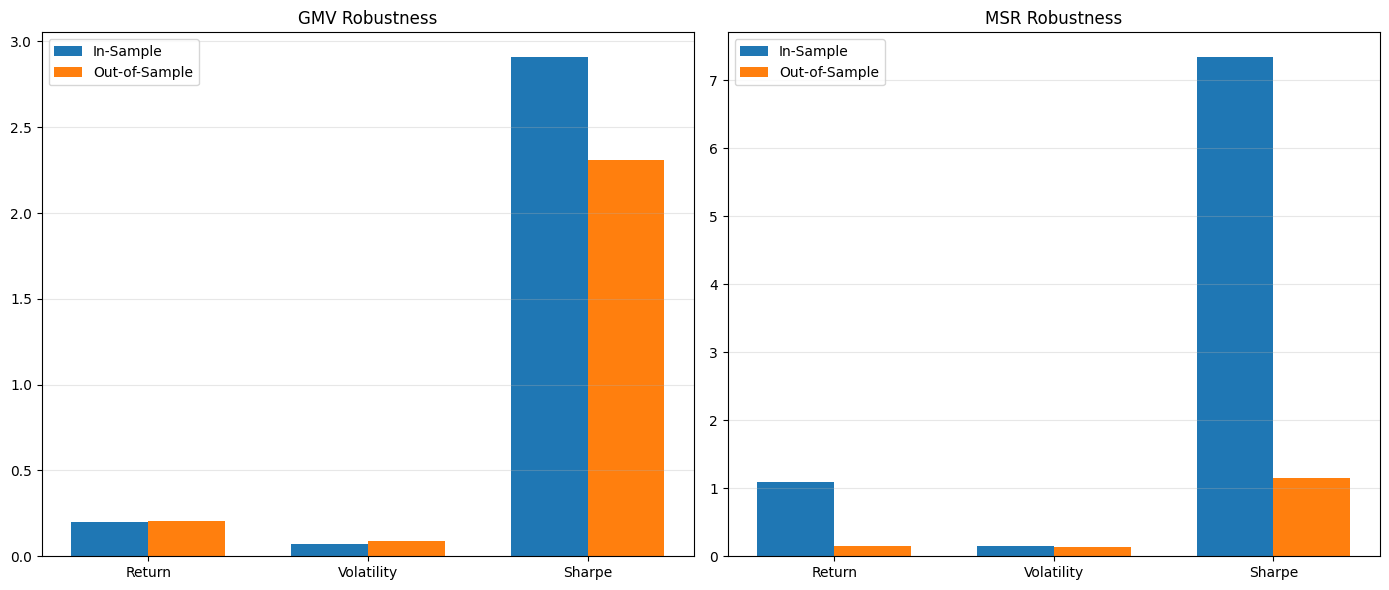

In [40]:
# GMV Comparison
gmv_is_stats = portfolio_metrics(w_gmv_clip, is_returns, cov_clip)
gmv_oos_stats = portfolio_metrics(w_gmv_clip, oos_returns, cov_clip)

# MSR Comparison
msr_is_stats = portfolio_metrics(w_msr_clip, is_returns, cov_clip)
msr_oos_stats = portfolio_metrics(w_msr_clip, oos_returns, cov_clip)

df_gmv = create_comparison_df(gmv_is_stats, gmv_oos_stats, "GMV")
df_msr = create_comparison_df(msr_is_stats, msr_oos_stats, "MSR")

comparison_table = pd.concat([df_gmv, df_msr])
cols_to_show = ["Return", "Volatility", "Sharpe", "Volatility Ratio"]
final_view = comparison_table[cols_to_show]

print("In-Sample vs Out-of-Sample")
pd.options.display.float_format = "{:,.2f}".format
print(final_view)

metrics = ['Return', 'Volatility', 'Sharpe']
x = np.arange(len(metrics))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# GMV Plot
rects1 = axes[0].bar(x - width/2, [gmv_is_stats[m] for m in metrics], width, label='In-Sample')
rects2 = axes[0].bar(x + width/2, [gmv_oos_stats[m] for m in metrics], width, label='Out-of-Sample')
axes[0].set_title(f'GMV Robustness')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# MSR Plot
rects3 = axes[1].bar(x - width/2, [msr_is_stats[m] for m in metrics], width, label='In-Sample')
rects4 = axes[1].bar(x + width/2, [msr_oos_stats[m] for m in metrics], width, label='Out-of-Sample')
axes[1].set_title(f'MSR Robustness')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

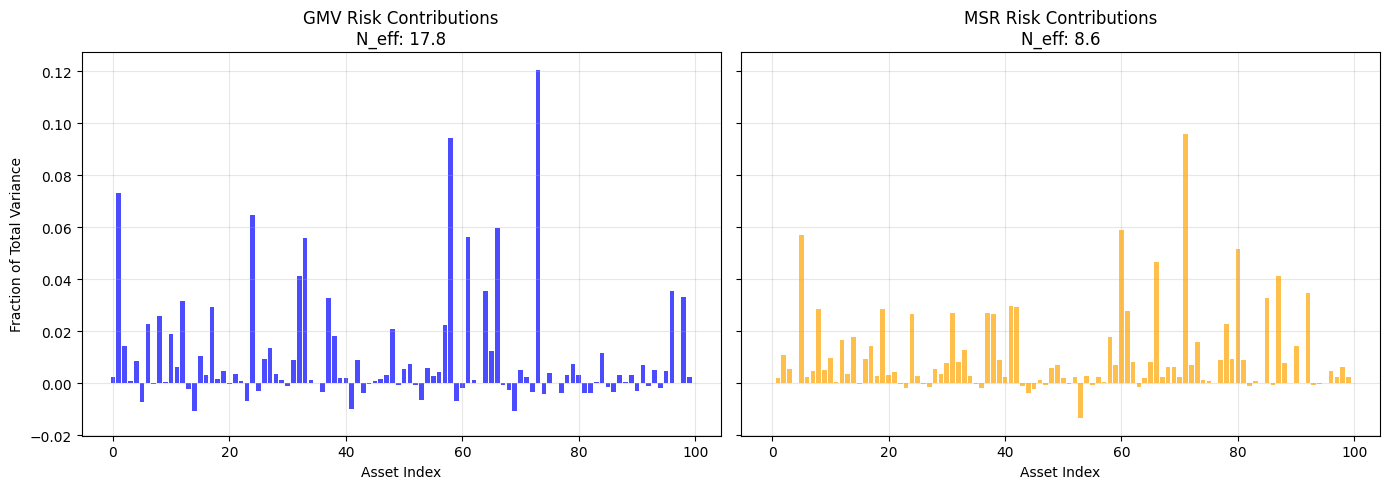

In [41]:
rc_gmv = get_risk_contribution(w_gmv_clip, cov_clip)
rc_msr = get_risk_contribution(w_msr_clip, cov_clip)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot GMV
axes[0].bar(range(len(rc_gmv)), rc_gmv, color='blue', alpha=0.7)
axes[0].set_title(f"GMV Risk Contributions\nN_eff: {gmv_is_stats['N_eff']:.1f}")
axes[0].set_ylabel("Fraction of Total Variance")
axes[0].set_xlabel("Asset Index")
axes[0].grid(alpha=0.3)

# Plot MSR
axes[1].bar(range(len(rc_msr)), rc_msr, color='orange', alpha=0.7)
axes[1].set_title(f"MSR Risk Contributions\nN_eff: {msr_is_stats['N_eff']:.1f}")
axes[1].set_xlabel("Asset Index")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

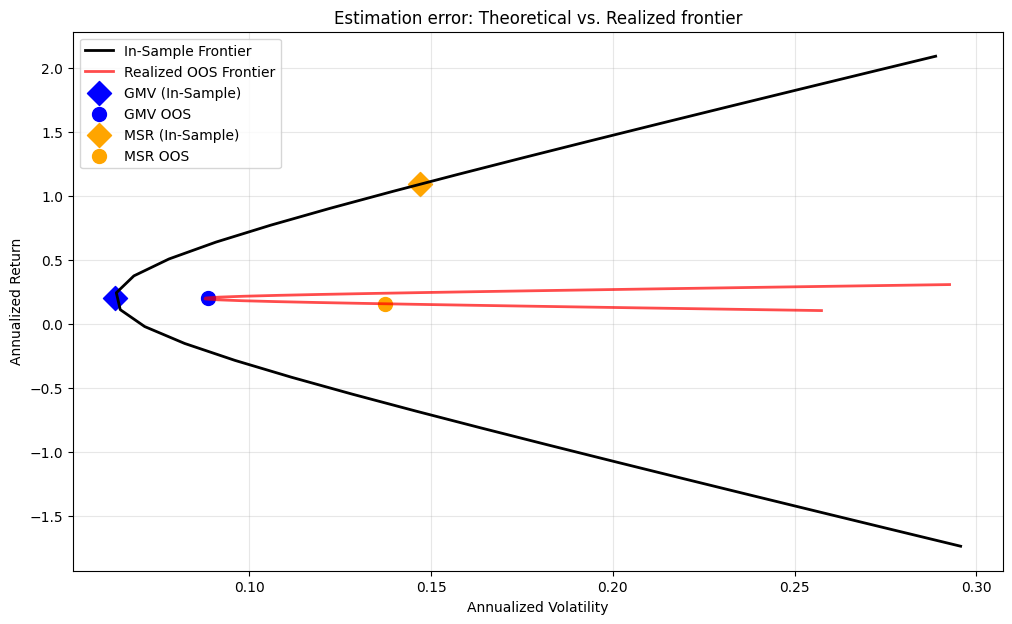

In [42]:
W_frontier, rets_target = efficient_frontier_weights(mu, cov_clip)

vol_is = []
vol_oos = []
ret_oos = []


for i, w in enumerate(W_frontier):
    # In-sample
    var_is = w @ cov_clip @ w
    vol_annual_is = np.sqrt(var_is) * np.sqrt(Ann)
    
    # Annualize the target return for the Y-axis
    ret_annual_is = rets_target[i] * Ann
    vol_is.append(vol_annual_is)
    
    # Out-of-sample 
    stats = portfolio_metrics(w, oos_returns) 
    
    vol_oos.append(stats["Volatility"])
    ret_oos.append(stats["Return"])


# Get GMV IS coordinates
gmv_ret_is = (w_gmv_clip @ mu) * Ann
gmv_vol_is = np.sqrt(w_gmv_clip @ cov_clip @ w_gmv_clip) * np.sqrt(Ann)
# Get GMV OOS coordinates 
gmv_stats_oos = portfolio_metrics(w_gmv_clip, oos_returns, cov_clip) 

# Get MSR IS coordinates
msr_ret_is = (w_msr_clip @ mu) * Ann
msr_vol_is = np.sqrt(w_msr_clip @ cov_clip @ w_msr_clip) * np.sqrt(Ann)
# Get MSR OOS coordinates
msr_stats_oos = portfolio_metrics(w_msr_clip, oos_returns, cov_clip)

plt.figure(figsize=(12, 7))

rets_target_annual = rets_target * Ann

plt.plot(vol_is, rets_target_annual, label="In-Sample Frontier", 
         color='black', lw=2)
plt.plot(vol_oos, ret_oos, label="Realized OOS Frontier", 
         color='red', lw=2, alpha=0.7)


# GMV 
plt.scatter(gmv_vol_is, gmv_ret_is, marker="D", s=150, c='blue', label="GMV (In-Sample)")
plt.scatter(gmv_stats_oos['Volatility'], gmv_stats_oos['Return'], 
            marker="o", s=100, c='blue', label="GMV OOS")


# MSR 
plt.scatter(msr_vol_is, msr_ret_is, marker="D", s=150, c='orange', label="MSR (In-Sample)")
plt.scatter(msr_stats_oos['Volatility'], msr_stats_oos['Return'], 
            marker="o", s=100, c='orange', label="MSR OOS")


plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Estimation error: Theoretical vs. Realized frontier")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

b) Cross-Validated (CV) eigenvalue shrinkage

In [43]:
from sklearn.isotonic import IsotonicRegression

def cv_shrinkage(returns, n_splits=50, split_ratio=0.9):
    """
    Performs cross-validation shrinkage on the Correlation Matrix.
    """
    T, N = returns.shape
    
    volatilities = returns.std(ddof=1)  # Sample standard deviations
    
    norm_returns = returns / volatilities
    
    corr_full = norm_returns.cov()
    eigvals_full, eigvecs_full = np.linalg.eigh(corr_full)
    
    idx = eigvals_full.argsort()
    eigvals_full = eigvals_full[idx]
    eigvecs_full = eigvecs_full[:, idx]
    
    # Cross-Validation Loop
    lambda_cv_samples = []

    for _ in range(n_splits):
        # Shuffle
        indices = np.arange(T)
        np.random.shuffle(indices)
        
        cut = int(T * split_ratio)
        
        X_in = norm_returns.iloc[indices[:cut]].values
        X_out = norm_returns.iloc[indices[cut:]].values
        
        corr_in = np.cov(X_in, rowvar=False)
        vals_in, vecs_in = np.linalg.eigh(corr_in)
        
        idx_sort = vals_in.argsort()
        vecs_in = vecs_in[:, idx_sort]
        
        corr_out = np.cov(X_out, rowvar=False)
        out_of_sample_vars = np.diag(vecs_in.T @ corr_out @ vecs_in)
        
        lambda_cv_samples.append(out_of_sample_vars)

    # Average the CV variance estimates
    lambda_cv_mean = np.mean(lambda_cv_samples, axis=0)
    
    # Isotonic regression 
    ir = IsotonicRegression(out_of_bounds='clip')
    # X = observed eigenvalues, Y = CV estimates
    lambda_cleaned = ir.fit_transform(eigvals_full, lambda_cv_mean)
    
    corr_cv = eigvecs_full @ np.diag(lambda_cleaned) @ eigvecs_full.T
    
    np.fill_diagonal(corr_cv, 1.0)

    vol_outer_product = np.outer(volatilities, volatilities)
    cov_cv = corr_cv * vol_outer_product
    
    return cov_cv, lambda_cleaned, corr_cv

cov_cv, eigvals_clean, corr_cv = cv_shrinkage(is_returns)

w_gmv_cv, _, _ = gmv(mu, cov_cv)
w_msr_cv, _, _ = msr(mu, cov_cv)


In-Sample vs Out-of-Sample
           Return  Volatility  Sharpe  Volatility Ratio
GMV (IS)     0.21        0.07    3.15              1.03
GMV (OOS)    0.21        0.09    2.34              1.39
MSR (IS)     1.08        0.14    7.67              0.96
MSR (OOS)    0.18        0.14    1.34              0.93


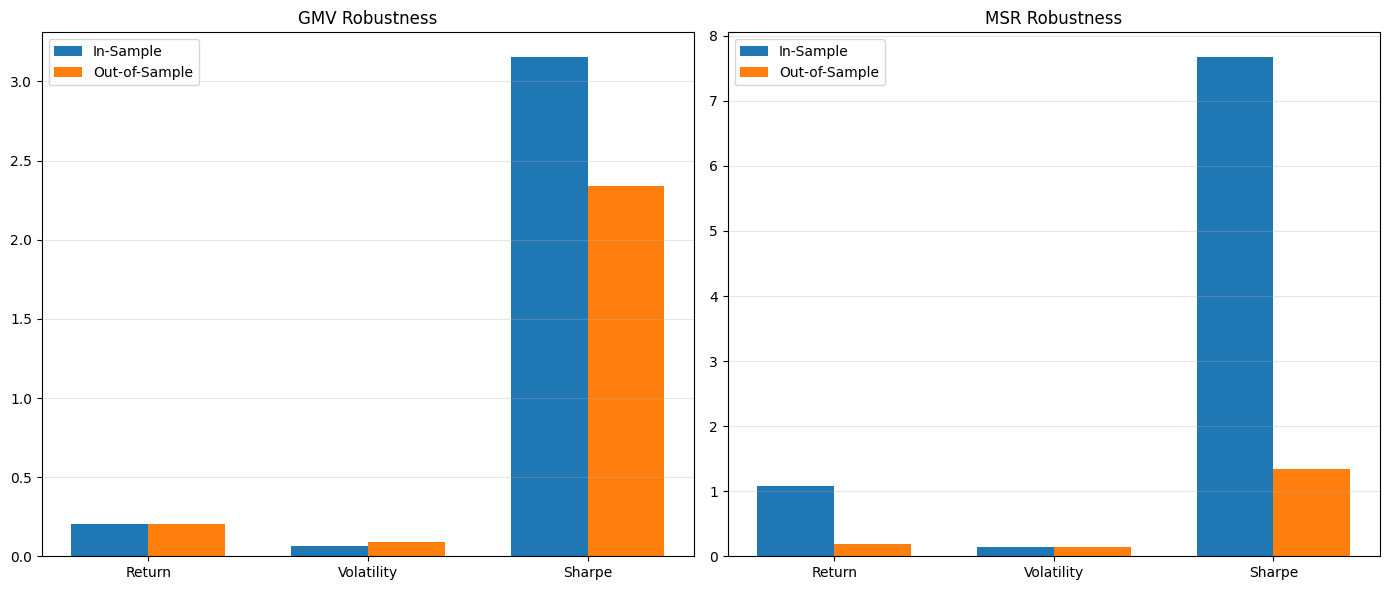

In [44]:
# GMV Comparison
gmv_is_stats = portfolio_metrics(w_gmv_cv, is_returns, cov_cv)
gmv_oos_stats = portfolio_metrics(w_gmv_cv, oos_returns, cov_cv)

# MSR Comparison
msr_is_stats = portfolio_metrics(w_msr_cv, is_returns, cov_cv)
msr_oos_stats = portfolio_metrics(w_msr_cv, oos_returns, cov_cv)

df_gmv = create_comparison_df(gmv_is_stats, gmv_oos_stats, "GMV")
df_msr = create_comparison_df(msr_is_stats, msr_oos_stats, "MSR")

comparison_table = pd.concat([df_gmv, df_msr])
cols_to_show = ["Return", "Volatility", "Sharpe", "Volatility Ratio"]
final_view = comparison_table[cols_to_show]

print("In-Sample vs Out-of-Sample")
pd.options.display.float_format = "{:,.2f}".format
print(final_view)

metrics = ['Return', 'Volatility', 'Sharpe']
x = np.arange(len(metrics))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# GMV Plot
rects1 = axes[0].bar(x - width/2, [gmv_is_stats[m] for m in metrics], width, label='In-Sample')
rects2 = axes[0].bar(x + width/2, [gmv_oos_stats[m] for m in metrics], width, label='Out-of-Sample')
axes[0].set_title(f'GMV Robustness')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# MSR Plot
rects3 = axes[1].bar(x - width/2, [msr_is_stats[m] for m in metrics], width, label='In-Sample')
rects4 = axes[1].bar(x + width/2, [msr_oos_stats[m] for m in metrics], width, label='Out-of-Sample')
axes[1].set_title(f'MSR Robustness')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

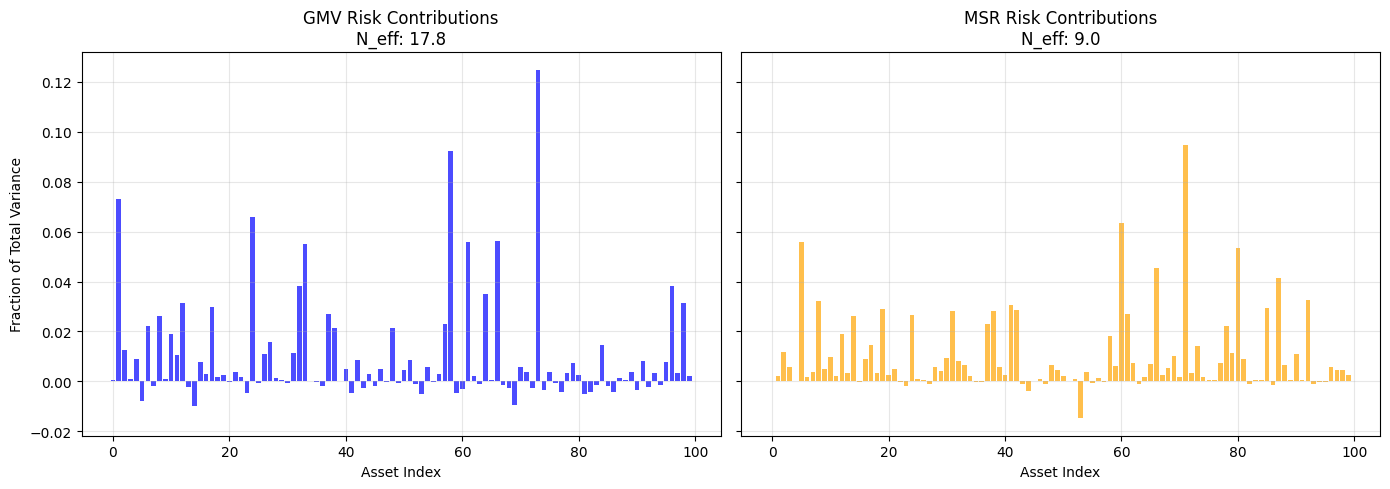

In [45]:
rc_gmv = get_risk_contribution(w_gmv_cv, cov_cv)
rc_msr = get_risk_contribution(w_msr_cv, cov_cv)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot GMV
axes[0].bar(range(len(rc_gmv)), rc_gmv, color='blue', alpha=0.7)
axes[0].set_title(f"GMV Risk Contributions\nN_eff: {gmv_is_stats['N_eff']:.1f}")
axes[0].set_ylabel("Fraction of Total Variance")
axes[0].set_xlabel("Asset Index")
axes[0].grid(alpha=0.3)

# Plot MSR
axes[1].bar(range(len(rc_msr)), rc_msr, color='orange', alpha=0.7)
axes[1].set_title(f"MSR Risk Contributions\nN_eff: {msr_is_stats['N_eff']:.1f}")
axes[1].set_xlabel("Asset Index")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

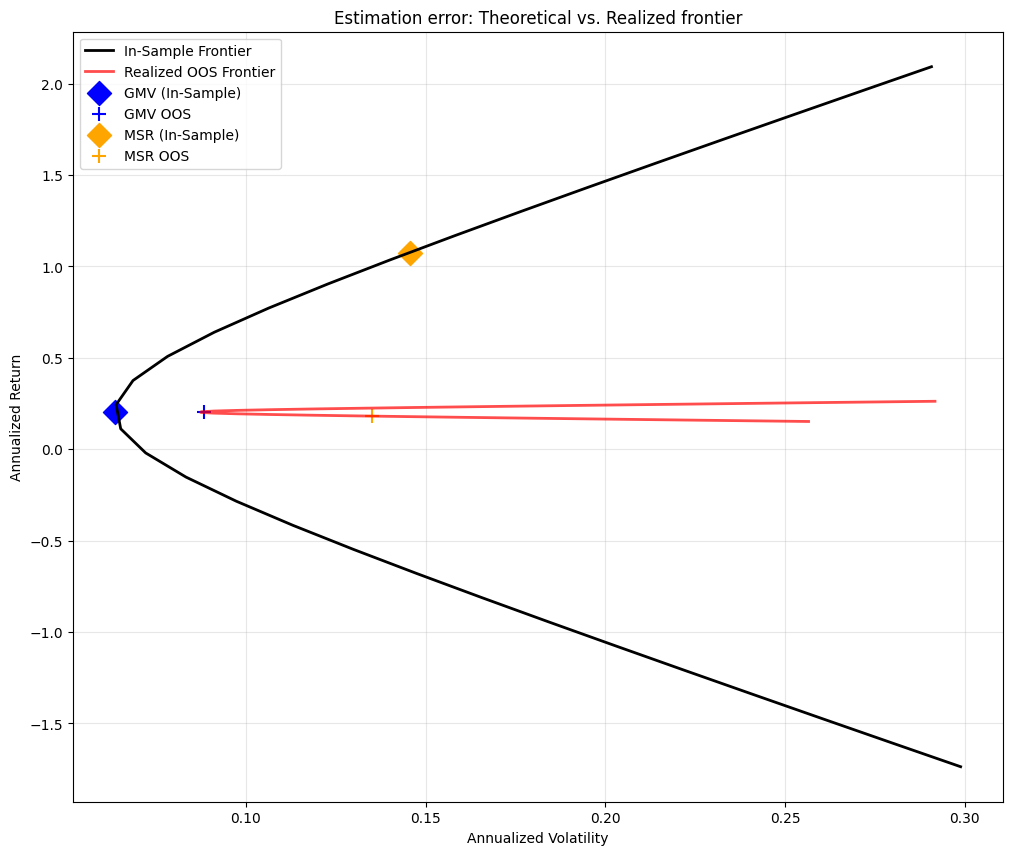

In [46]:
W_frontier, rets_target = efficient_frontier_weights(mu, cov_cv)

vol_is = []
vol_oos = []
ret_oos = []


for i, w in enumerate(W_frontier):
    # In-Sample
    var_is = w @ cov_cv @ w
    vol_annual_is = np.sqrt(var_is) * np.sqrt(Ann)
    
    # Annualizing
    ret_annual_is = rets_target[i] * Ann
    vol_is.append(vol_annual_is)
    
    # Out-of-Sample
    stats = portfolio_metrics(w, oos_returns) 
    
    vol_oos.append(stats["Volatility"])
    ret_oos.append(stats["Return"])

# Get GMV IS coordinates
gmv_ret_is = (w_gmv_cv.T @ mu) * Ann
gmv_vol_is = np.sqrt(w_gmv_cv.T @ cov_cv @ w_gmv_cv) * np.sqrt(Ann)
# Get GMV OOS coordinates
gmv_stats_oos = portfolio_metrics(w_gmv_cv, oos_returns, cov_cv) 

# Get MSR IS coordinates
msr_ret_is = (w_msr_cv.T @ mu) * Ann
msr_vol_is = np.sqrt(w_msr_cv.T @ cov_cv @ w_msr_cv) * np.sqrt(Ann)
# Get MSR OOS coordinates 
msr_stats_oos = portfolio_metrics(w_msr_cv, oos_returns, cov_cv)


plt.figure(figsize=(12, 10))

rets_target_annual = rets_target * Ann

plt.plot(vol_is, rets_target_annual, label="In-Sample Frontier", 
         color='black', lw=2)
plt.plot(vol_oos, ret_oos, label="Realized OOS Frontier", 
         color='red', lw=2, alpha=0.7)


# GMV Connection
plt.scatter(gmv_vol_is, gmv_ret_is, marker="D", s=150, c='blue', label="GMV (In-Sample)")
plt.scatter(gmv_stats_oos['Volatility'], gmv_stats_oos['Return'], 
            marker="+", s=100, c='blue', label="GMV OOS")


# MSR Connection
plt.scatter(msr_vol_is, msr_ret_is, marker="D", s=150, c='orange', label="MSR (In-Sample)")
plt.scatter(msr_stats_oos['Volatility'], msr_stats_oos['Return'], 
            marker="+", s=100, c='orange', label="MSR OOS")


plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Estimation error: Theoretical vs. Realized frontier")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

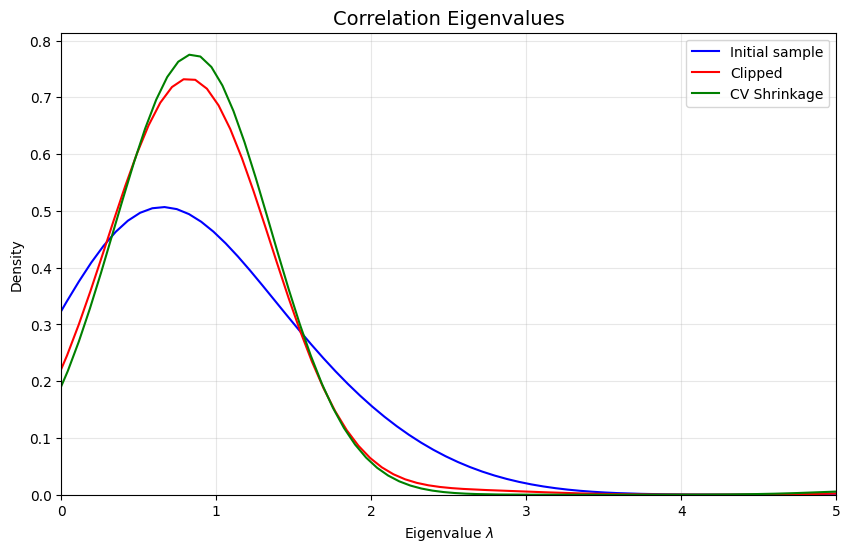

In [47]:
eigvals_sample_corr = np.linalg.eigvalsh(is_returns.corr())

# CV Shrinkage
eigvals_cv_corr = np.linalg.eigvalsh(corr_cv)

# Clipped
eigvals_clip_corr = np.linalg.eigvalsh(corr_clip)


plt.figure(figsize=(10, 6))

sns.kdeplot(eigvals_sample_corr, label="Initial sample", color='blue')
sns.kdeplot(eigvals_clip_corr, label="Clipped", color='red')
sns.kdeplot(eigvals_cv_corr, label="CV Shrinkage", color='green')

plt.title("Correlation Eigenvalues", fontsize=14)
plt.xlabel("Eigenvalue $\lambda$")
plt.ylabel("Density")
plt.xlim(0, 5)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In the eigenvalue density plot, the sample (blue) curve exhibits a wide dispersion notably with a thick left tail toward zero. This is critical because portfolio weights are proportional to the inverse of the covariance matrix ($\Sigma^{-1}$). Consequently, the optimizer misinterprets these near-zero eigenvalues, which arise purely from spurious sampling noise due to the insufficient observation period $T$ relative to assets $N$—as low-risk arbitrage opportunities. This causes the model to drastically underestimate risk and allocate extreme leverage to statistical noise. The Clipped (Orange) curve, and even more drastically the CV curve (green) collapse this noisy wide curve into a single sharp peak with thinner tails. Importantly, these peaks are not located at zero, but closer to 0.8-1. This forces the optimizer to acknowledge that these assets are not risk-free.

In [48]:
#CHECK WHY THE BIAS RATIO NOT 1 FOR IS FOR THE TWO CLEANED METHODS
#comment WHY SHARPE WORSE FOR MAX SHARPE PORTFOLIO + comment whole notebook
#pas fait l'oracle pour 2b

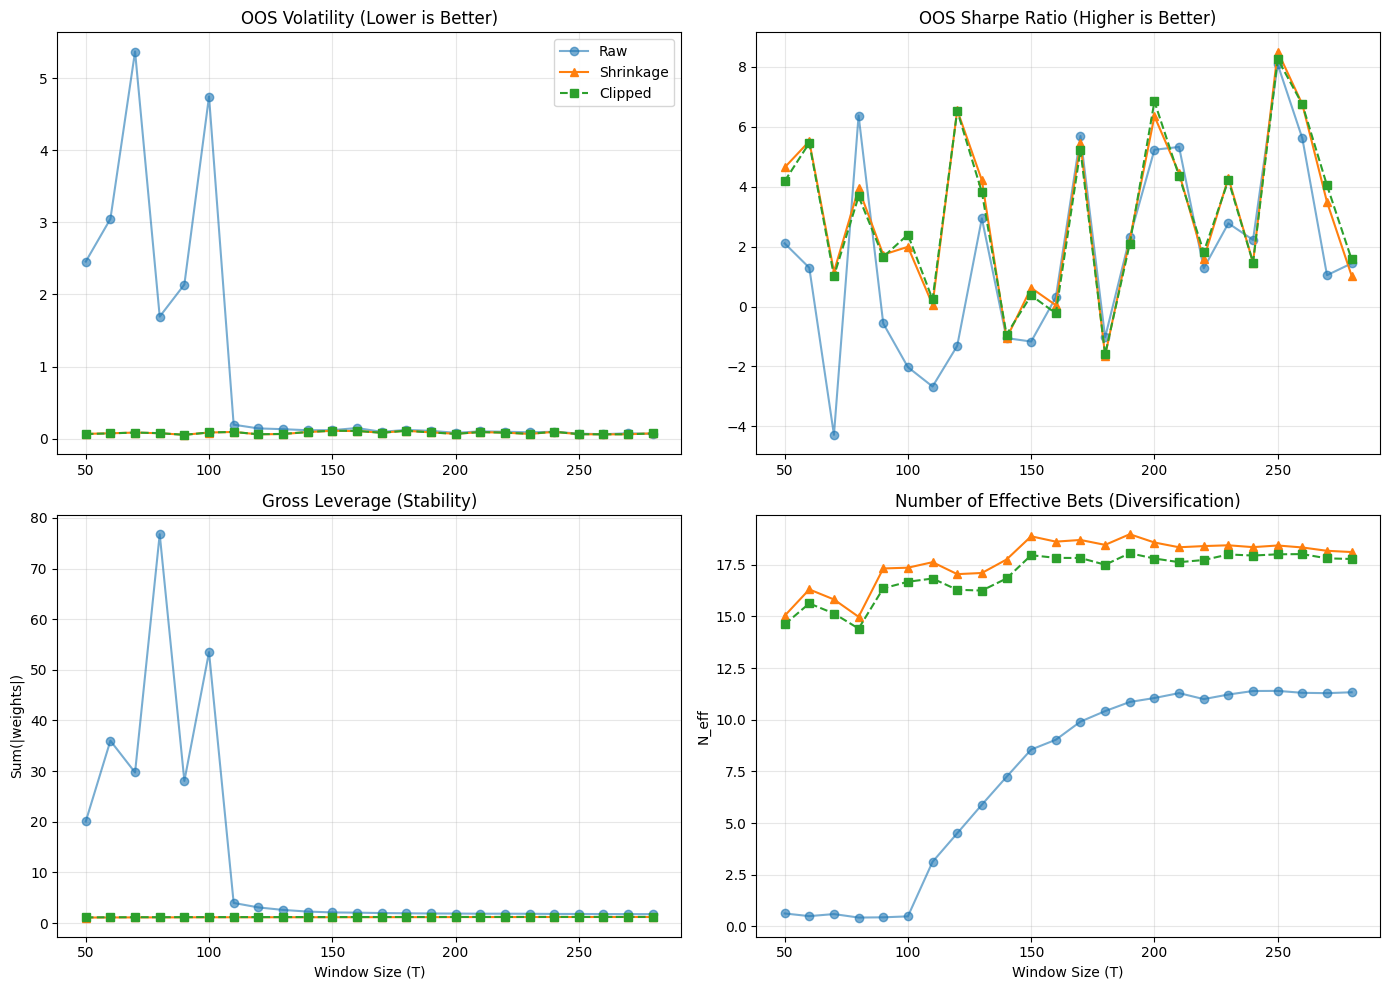

In [49]:
def get_gross_leverage(w):
    """Sum of absolute weights."""
    return np.sum(np.abs(w))

def get_n_eff(w):
    """Effective diversification."""
    sum_sq = np.sum(w**2)
    return 1.0 / sum_sq

max_T = len(is_returns) - 10
window_sizes = [t for t in range(50, 301, 10) if t < max_T] 
results = []
N_assets = is_returns.shape[1]

for T in window_sizes:
    raw_rets, clean_rets, clipped_rets = [], [], []
    raw_lev, clean_lev, clipped_lev = [], [], []
    raw_neff, clean_neff, clipped_neff = [], [], []
    
    for _ in range(50): 
        start_idx = np.random.randint(0, len(is_returns) - T - 1)
        is_window = is_returns.iloc[start_idx : start_idx + T]
        oos_day = is_returns.iloc[start_idx + T]
        
        # raw
        cov_raw = is_window.cov().values
        w_raw, _, _ = gmv(mu, cov_raw) 
        
        raw_rets.append(np.dot(w_raw, oos_day.values))
        raw_lev.append(get_gross_leverage(w_raw))
        raw_neff.append(get_n_eff(w_raw))
        
        #CV Shrinkage
        cov_clean, _, _ = cv_shrinkage(is_window) 
        w_clean, _, _ = gmv(mu, cov_clean)
        
        clean_rets.append(np.dot(w_clean, oos_day.values))
        clean_lev.append(get_gross_leverage(w_clean))
        clean_neff.append(get_n_eff(w_clean))
        
        #Clipped
        q = T / N_assets
        _,cov_clipped,_ = eigenvalue_clipping(cov_raw, q)
        w_clipped, _, _ = gmv(mu, cov_clipped)
        
        clipped_rets.append(np.dot(w_clipped, oos_day.values))
        clipped_lev.append(get_gross_leverage(w_clipped))
        clipped_neff.append(get_n_eff(w_clipped))
        
    factor = np.sqrt(252)
    
    results.append({
        "Window": T,
        
        "Raw Vol": np.std(raw_rets) * factor,
        "Clean Vol": np.std(clean_rets) * factor,
        "Clipped Vol": np.std(clipped_rets) * factor,
        "Raw Sharpe": (np.mean(raw_rets) / np.std(raw_rets)) * factor,
        "Clean Sharpe": (np.mean(clean_rets) / np.std(clean_rets)) * factor,
        "Clipped Sharpe": (np.mean(clipped_rets) / np.std(clipped_rets)) * factor,
        
        "Raw Lev": np.mean(raw_lev),
        "Clean Lev": np.mean(clean_lev),
        "Clipped Lev": np.mean(clipped_lev),
        "Raw Neff": np.mean(raw_neff),
        "Clean Neff": np.mean(clean_neff),
        "Clipped Neff": np.mean(clipped_neff)
    })

df_res = pd.DataFrame(results).set_index("Window")

fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# 1. Volatility
ax[0, 0].plot(df_res.index, df_res["Raw Vol"], label="Raw", marker='o', alpha=0.6)
ax[0, 0].plot(df_res.index, df_res["Clean Vol"], label="Shrinkage", marker='^')
ax[0, 0].plot(df_res.index, df_res["Clipped Vol"], label="Clipped", marker='s', linestyle='--')
ax[0, 0].set_title("OOS Volatility (Lower is Better)")
ax[0, 0].legend()
ax[0, 0].grid(True, alpha=0.3)

# 2. Sharpe
ax[0, 1].plot(df_res.index, df_res["Raw Sharpe"], label="Raw", marker='o', alpha=0.6)
ax[0, 1].plot(df_res.index, df_res["Clean Sharpe"], label="Shrinkage", marker='^')
ax[0, 1].plot(df_res.index, df_res["Clipped Sharpe"], label="Clipped", marker='s', linestyle='--')
ax[0, 1].set_title("OOS Sharpe Ratio (Higher is Better)")
ax[0, 1].grid(True, alpha=0.3)

# 3. Gross Leverage
ax[1, 0].plot(df_res.index, df_res["Raw Lev"], label="Raw", marker='o', alpha=0.6)
ax[1, 0].plot(df_res.index, df_res["Clean Lev"], label="Shrinkage", marker='^')
ax[1, 0].plot(df_res.index, df_res["Clipped Lev"], label="Clipped", marker='s', linestyle='--')
ax[1, 0].set_title("Gross Leverage (Stability)")
ax[1, 0].set_ylabel("Sum(|weights|)")
ax[1, 0].set_xlabel("Window Size (T)")
ax[1, 0].grid(True, alpha=0.3)

# 4. N_eff (Higher means more diversified)
ax[1, 1].plot(df_res.index, df_res["Raw Neff"], label="Raw", marker='o', alpha=0.6)
ax[1, 1].plot(df_res.index, df_res["Clean Neff"], label="Shrinkage", marker='^')
ax[1, 1].plot(df_res.index, df_res["Clipped Neff"], label="Clipped", marker='s', linestyle='--')
ax[1, 1].set_title("Number of Effective Bets (Diversification)")
ax[1, 1].set_ylabel("N_eff")
ax[1, 1].set_xlabel("Window Size (T)")
ax[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

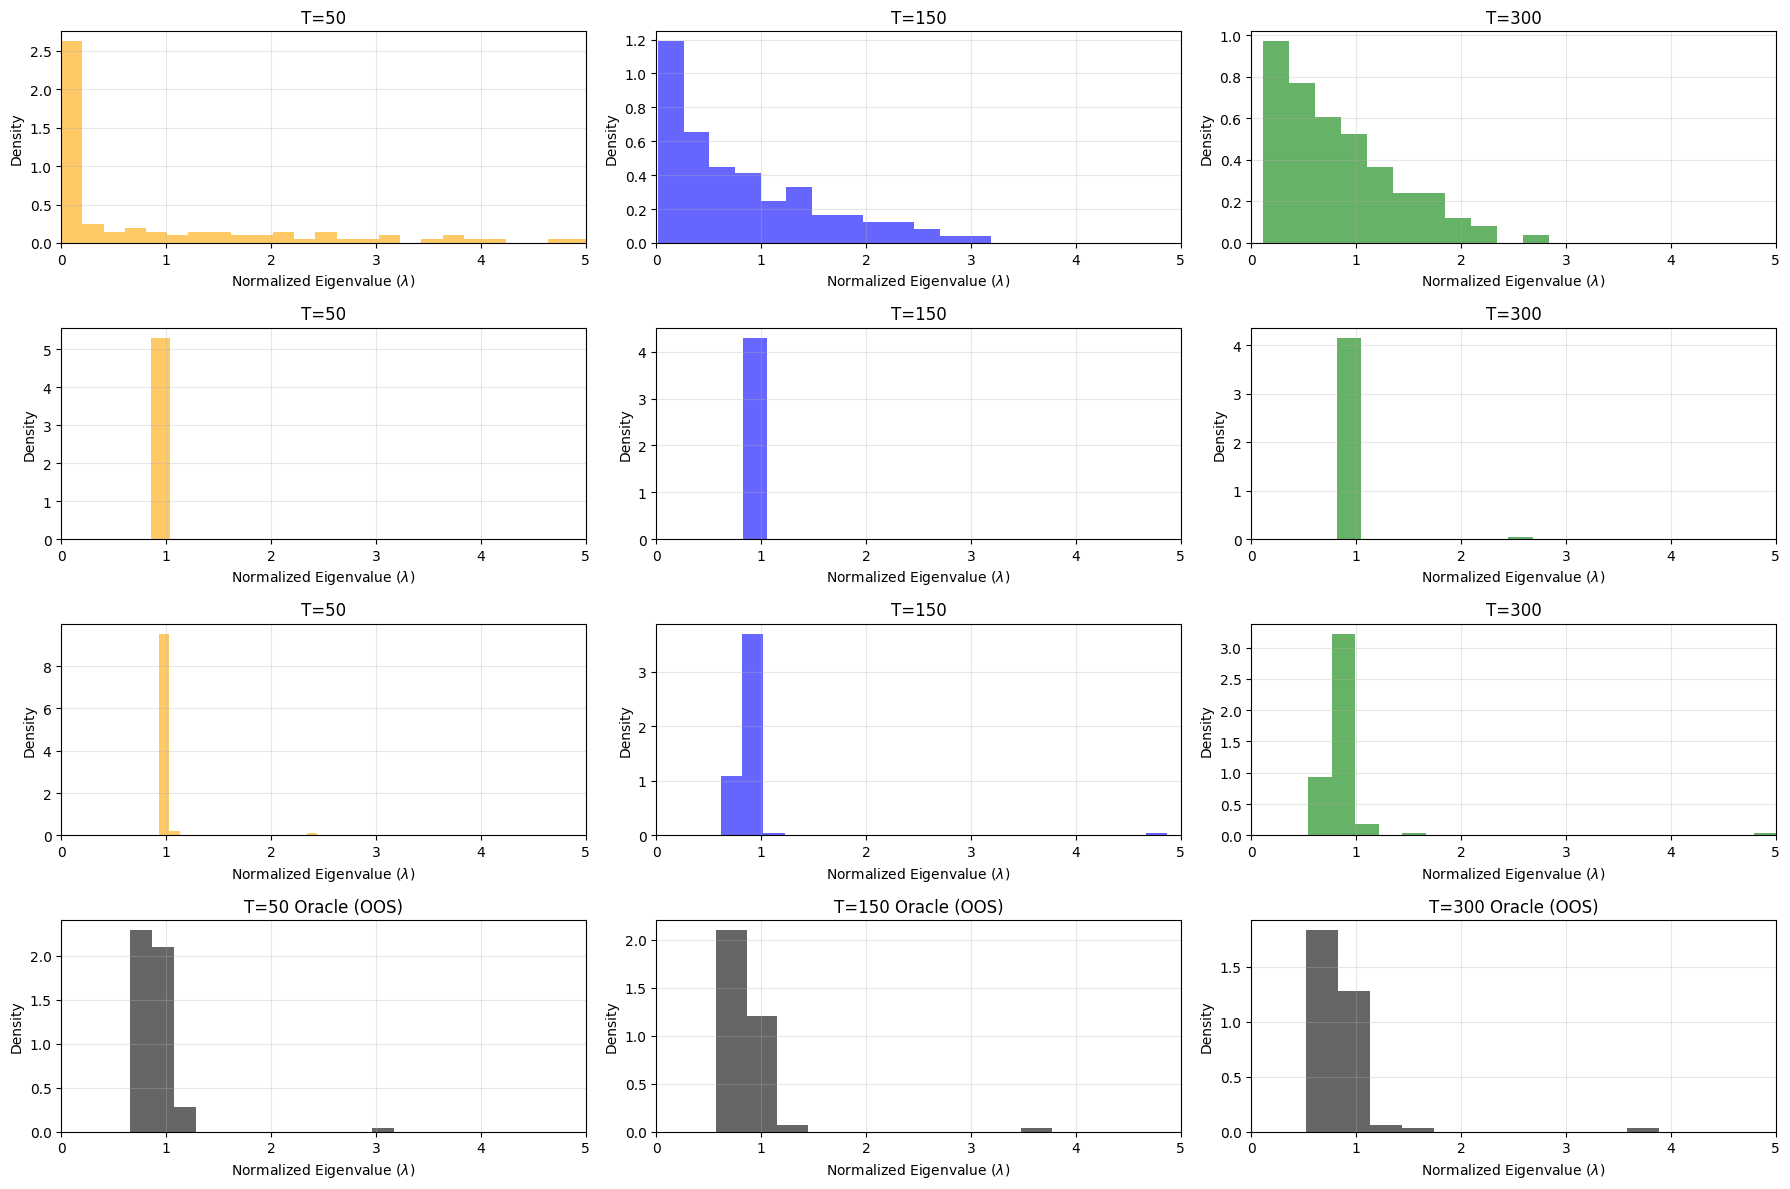

In [51]:
from scipy.linalg import eigh

def plot_hist(ax, evals, title, color='tab:blue'):
    evals_norm = evals / np.mean(evals)
    
    ax.hist(evals_norm, bins=50, density=True, alpha=0.6, color=color, label="Eigenvalues")
    ax.set_title(title)
    ax.set_xlim(0, 5.0)
    ax.set_xlabel("Normalized Eigenvalue ($\lambda$)")
    ax.set_ylabel("Density")
    ax.grid(alpha=0.3)

# 1. T = 50 (Noisy)
slice_50 = is_returns.iloc[:50]
corr_50 = slice_50.corr().values
evals_50, eigvecs_50 = eigh(corr_50)

# 2. T = 150 (More Signal)
slice_150 = is_returns.iloc[:150]
corr_150 = slice_150.corr().values
evals_150, eigvecs_150 = eigh(corr_150)

# 2. T = 300 (More Signal)
slice_300 = is_returns.iloc[:300]
corr_300 = slice_300.corr().values
evals_300, eigvecs_300 = eigh(corr_300)

# 3. T = 50 (Clipped)
cov_50_input = slice_50.cov().values
q_50 = 50 / cov_50_input.shape[0]

cov_150_input = slice_150.cov().values
q_150 = 150 / cov_150_input.shape[0]

cov_300_input = slice_300.cov().values
q_300 = 300 / cov_300_input.shape[0]

_, _, evals_50_clipped = eigenvalue_clipping(cov_50_input, q_50)
_, _, evals_150_clipped = eigenvalue_clipping(cov_150_input, q_150)
_, _, evals_300_clipped = eigenvalue_clipping(cov_300_input, q_300)


_, eigvals_cv50, _ = cv_shrinkage(slice_50)
_, eigvals_cv150, _ = cv_shrinkage(slice_150)
_, eigvals_cv300, _ = cv_shrinkage(slice_300)

# Oracle from OOS data
cov_out = oos_returns.cov().values
vol_out = np.sqrt(np.diag(cov_out))
corr_out = np.diag(1/vol_out) @ cov_out @ np.diag(1/vol_out)

evals_oracle_50 = np.diag(eigvecs_50.T @ corr_out @ eigvecs_50)
evals_oracle_150 = np.diag(eigvecs_150.T @ corr_out @ eigvecs_150)
evals_oracle_300 = np.diag(eigvecs_300.T @ corr_out @ eigvecs_300)

fig, axes = plt.subplots(4, 3, figsize=(18, 12))

plot_hist(axes[0,0], evals_50, "T=50", color='orange')
plot_hist(axes[0,1], evals_150, "T=150", color='blue')
plot_hist(axes[0,2], evals_300, "T=300", color='green')

plot_hist(axes[1,0], evals_50_clipped, "T=50", color='orange')
plot_hist(axes[1,1], evals_150_clipped, "T=150", color='blue')
plot_hist(axes[1,2], evals_300_clipped, "T=300", color='green')


plot_hist(axes[2,0], eigvals_cv50, "T=50", color='orange')
plot_hist(axes[2,1], eigvals_cv150, "T=150", color='blue')
plot_hist(axes[2,2], eigvals_cv300, "T=300", color='green')


plot_hist(axes[3,0], evals_oracle_50, "T=50 Oracle (OOS)", color='black')
plot_hist(axes[3,1], evals_oracle_150, "T=150 Oracle (OOS)", color='black')
plot_hist(axes[3,2], evals_oracle_300, "T=300 Oracle (OOS)", color='black')


plt.tight_layout()
plt.show()